#  Application of Machine Learning Techniques to State-Of-Charge Estimation of Calendar-aged Lithium-ion Batteries
Various machine learning algorithms have been used to estimate state-of-charge (SOC) of calendar-aged lithium-ion pouch cells. Calendar life data was generated by applying galvanostatic charge/discharge cycle loads at different storage temperature (35°C and 60°C) and conditions (fully-discharged and fully-charged). The data was obtained at various C-rates for duration of 10 months at one-month intervals. The wininng model, Random Forest (RF), has achieved a R2 score of 99.98% and a mean absolute error (MAE) of 0.14% over test data, confirming the ability of RF to capture input-output dependency. The model will be employed to estimate the SOC of calendar-aged lithium-ion batteries which is essential for the reliable operation of electic vehicles (EVs).  

## Library Imports

In [1]:
# Numpy and Pandas 
import numpy as np
import pandas as pd

# Vizualization
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# Machine learning algorithms
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Machine learning pipeline 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Regression Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Ignore ConvergenceWarning messages
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# Check the fitted_model
from sklearn.exceptions import NotFittedError

# Save python obect to disk
import pickle

## Exploratory Analysis

In [2]:
df = pd.read_csv('soh.csv')
df.head()

,SOH,month,Temp,Charged
0,0.975434,0,0,0
1,0.984243,1,0,0
2,0.992927,2,0,0
3,0.993066,3,0,0
4,0.992711,4,0,0


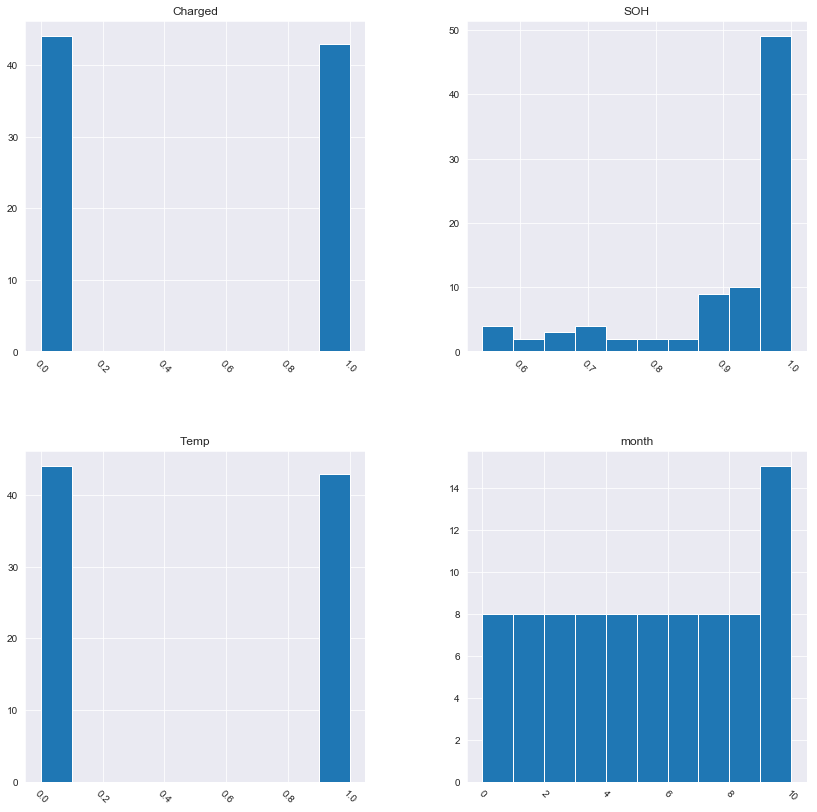

In [3]:
df.hist(figsize=(14,14), xrot=-45)
plt.show()

In [4]:
df.describe()

,SOH,month,Temp,Charged
count,87.000000,87.000000,87.000000,87.000000
mean,0.898660,4.942529,0.494253,0.494253
std,0.124104,3.152542,0.502865,0.502865
min,0.544034,0.000000,0.000000,0.000000
25%,0.878844,2.000000,0.000000,0.000000
50%,0.963619,5.000000,0.000000,0.000000
75%,0.979417,8.000000,1.000000,1.000000
max,1.000000,10.000000,1.000000,1.000000


In [5]:
df.Voltage.hist()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'Voltage'

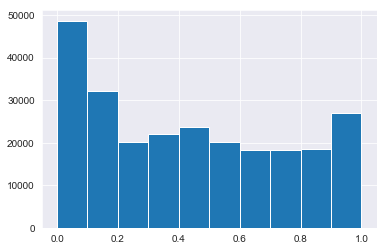

In [6]:
df.SOC.hist()
plt.show()

In [7]:
df.shape

(249205, 6)

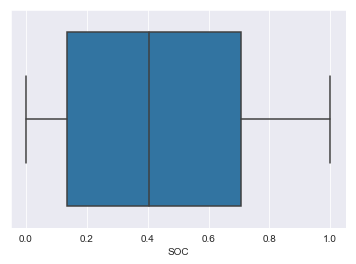

In [8]:
sns.boxplot(df.SOC)
plt.show()

C:\Users\a2ghorba\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


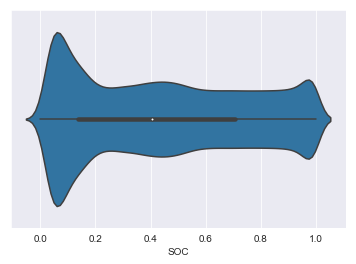

In [9]:
sns.violinplot('SOC', data=df)
plt.show()

In [10]:
correlations = df.corr()
correlations

,SOC,Current,Voltage,month,Temp,Charged
SOC,1.000000,0.021954,0.878562,0.071401,0.100932,0.163667
Current,0.021954,1.000000,-0.126238,0.005347,0.016609,0.019463
Voltage,0.878562,-0.126238,1.000000,-0.016586,-0.019551,-0.018495
month,0.071401,0.005347,-0.016586,1.000000,-0.009545,-0.014474
Temp,0.100932,0.016609,-0.019551,-0.009545,1.000000,-0.022347
Charged,0.163667,0.019463,-0.018495,-0.014474,-0.022347,1.000000


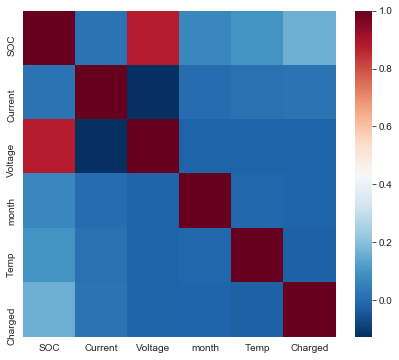

In [11]:
plt.figure(figsize=(7,6))
sns.heatmap(correlations, cmap='RdBu_r')
plt.show()

## Data Cleaning

In [6]:
print(df.shape)
df = df.drop_duplicates()
df['month'] = df['month'].astype(float)
df['Temp'] = df['Temp'].astype(float)
df['Charged'] = df['Charged'].astype(float)

(87, 4)


C:\Users\a2ghorba\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\a2ghorba\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\a2ghorba\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

## Feature Engineering

In [13]:
# Average of previous Vavg_num of data as a new feature
Vavg_num = 100
V = []
V[:Vavg_num] = df.Voltage[:Vavg_num]
for i in range(Vavg_num,len(df.Voltage)):
    V.append(np.mean(df.Voltage[i-Vavg_num:i]))
df['Vmean'] = V

In [14]:
df.tail()

,SOC,Current,Voltage,month,Temp,Charged,Vmean
249200,0.523254,30.0000,2.8074,10.0,1.0,1.0,2.888221
249201,0.523149,29.9977,2.8054,10.0,1.0,1.0,2.886684
249202,0.523037,30.0000,2.8037,10.0,1.0,1.0,2.885141
249203,0.522942,29.9973,2.8021,10.0,1.0,1.0,2.883595
249204,0.522847,29.9995,2.8003,10.0,1.0,1.0,2.882046


## Algorithm Selection

In [8]:
y = df.SOH
X = df.drop('SOH', axis=1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1234)
pipelines = {
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state=123)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state=123)),
    'enet'  : make_pipeline(StandardScaler(), ElasticNet(random_state=123)), 
    'rf'    : make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
    'gb'    : make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=123))
}

In [10]:
# Check that we have all 5 model families, and that they are all pipelines
for key, value in pipelines.items():
    print( key, type(value) )

lasso <class 'sklearn.pipeline.Pipeline'>
ridge <class 'sklearn.pipeline.Pipeline'>
enet <class 'sklearn.pipeline.Pipeline'>
rf <class 'sklearn.pipeline.Pipeline'>
gb <class 'sklearn.pipeline.Pipeline'>


In [11]:
lasso_hyperparameters = { 
    'lasso__alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 5, 10] 
}

# Ridge hyperparameters
ridge_hyperparameters = { 
    'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]  
}

# Elastic Net hyperparameters
enet_hyperparameters = { 
    'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10],                        
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]  
}

# Random forest hyperparameters
rf_hyperparameters = { 
    'randomforestregressor__n_estimators' : [10, 20],
    'randomforestregressor__max_features': ['auto', 'sqrt', 0.33],
}

# Boosted tree hyperparameters
gb_hyperparameters = { 
    'gradientboostingregressor__n_estimators': [10, 20],
    'gradientboostingregressor__learning_rate' : [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [1, 3, 5]
}

# Create hyperparameters dictionary
hyperparameters = {
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters,
    'enet' : enet_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
}

In [12]:
for key in ['enet', 'gb', 'ridge', 'rf', 'lasso']:
    if key in hyperparameters:
        if type(hyperparameters[key]) is dict:
            print( key, 'was found in hyperparameters, and it is a grid.' )
        else:
            print( key, 'was found in hyperparameters, but it is not a grid.' )
    else:
        print( key, 'was not found in hyperparameters')

enet was found in hyperparameters, and it is a grid.
gb was found in hyperparameters, and it is a grid.
ridge was found in hyperparameters, and it is a grid.
rf was found in hyperparameters, and it is a grid.
lasso was found in hyperparameters, and it is a grid.


In [13]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

C:\Users\a2ghorba\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\a2ghorba\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


lasso has been fitted.
ridge has been fitted.


C:\Users\a2ghorba\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


enet has been fitted.


C:\Users\a2ghorba\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


rf has been fitted.
gb has been fitted.


C:\Users\a2ghorba\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [14]:
for name, model in fitted_models.items():
    try:
        pred = model.predict(X_test)
        print (name, 'has been fitted.')
    except NotFittedError as e:
        print(repr(e))

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.


## Model Selection

In [15]:
for name, model in fitted_models.items():
    print(name, model.best_score_)

lasso -2.3227398603711844
ridge -2.5645121664462818
enet -1.3348805735746956
rf 0.8184571549289696
gb 0.8276449753065576


In [16]:
for name,model in fitted_models.items():
    pred = fitted_models[name].predict(X_test)
    print(name)
    print('R2:', r2_score(y_test, pred))
    print('MAE:', mean_absolute_error(y_test, pred))

lasso
R2: 0.036867199108084
MAE: 0.047516084500047906
ridge
R2: 0.039964956036627086
MAE: 0.048656575784556455
enet
R2: 0.16117850441466264
MAE: 0.045536021217038744
rf
R2: 0.885186655506409
MAE: 0.01710071843305559
gb
R2: 0.8549757145597072
MAE: 0.018818620558004477


In [107]:
# RandomForest wins!

## Insight & Analysis

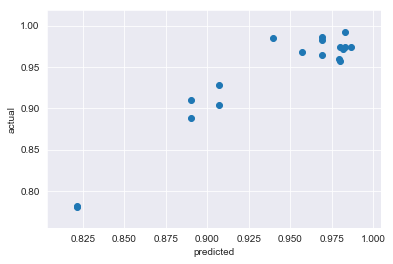

In [17]:
rf_pred = fitted_models['rf'].predict(X_test)
plt.scatter(rf_pred, y_test)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

In [25]:
fitted_models['rf'].best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=123, verbose=0, warm_start=False))])

In [26]:
with open('final_SOC_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)